#  Summary of what this capstone will, and may accomplish

* Scrape data from indeed, and return job postings
* properly format location, title, requirements (location done, 
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement
* Compare correlation between words used and position

Not required, but would be nice to implement
* add input to allow users to specifiy the cities to look at
* add a map to visualize how many postings there are in each city 

In [15]:
# Basic imports
import os
import time
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
DC_data = pd.read_csv('data/dc_data_scientist_indeed.csv', index_col=False)
DC_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
DC_data.shape

(791, 5)

In [4]:
# Preview the data
DC_data

,Title,Location,Company,Salary,Synopsis
0,Data Scientist - Entry to Experienced Level,None,National Security Agency,"\r\n $69,545 - $86,659 a year",Applying the scien...
1,Graduate Studies Program - Data Scientist,None,Central Intelligence Agency,\r\n $27.17 - $36.60 an hour,As a Data Scientis...
2,HP032 Data Technician,None,"ADNET Systems, Inc.",None,Work side by side ...
3,Analytic Consultant (Multiple Positions and Mu...,None,"ASR Analytics, LLC",None,ASR has an immedia...
4,Data Scientist - Entry to Experienced Level,"Fort Meade, MD",National Security Agency,"\r\n $69,545 - $86,659 a year",Applying the scientific process to...
5,Data Scientist,"Ballston, VA",Amazon.com,None,We are looking for Data Scientists...
6,Data Scientist [Remote],"Gaithersburg, MD",MRP,\r\n $80 - $120 an hour,Area is seeking a Data Scientist a...
7,Data Scientist,"Arlington, VA 22201 (Lyon Village area)",Elder Research Inc,None,While we do not have any openings ...
8,Part-Time Data Scientist,"Beltsville, MD",LAC Group,\r\n $25 - $30 an hour,Coursework or one year of work exp...
9,"Data Scientist, Client Experience / Research a...","Washington, DC",Deloitte,None,"Data Scientist, Client Experience / Research &..."


In [5]:
# Doing some data cleaning
for i, row in DC_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (DC_data['Location'][i]) = ' '.join((DC_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (DC_data['Synopsis'][i]) = (DC_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
DC_data.select_dtypes(include=['object']).nunique()

Title        43
Location     23
Company      65
Salary       14
Synopsis    105
dtype: int64

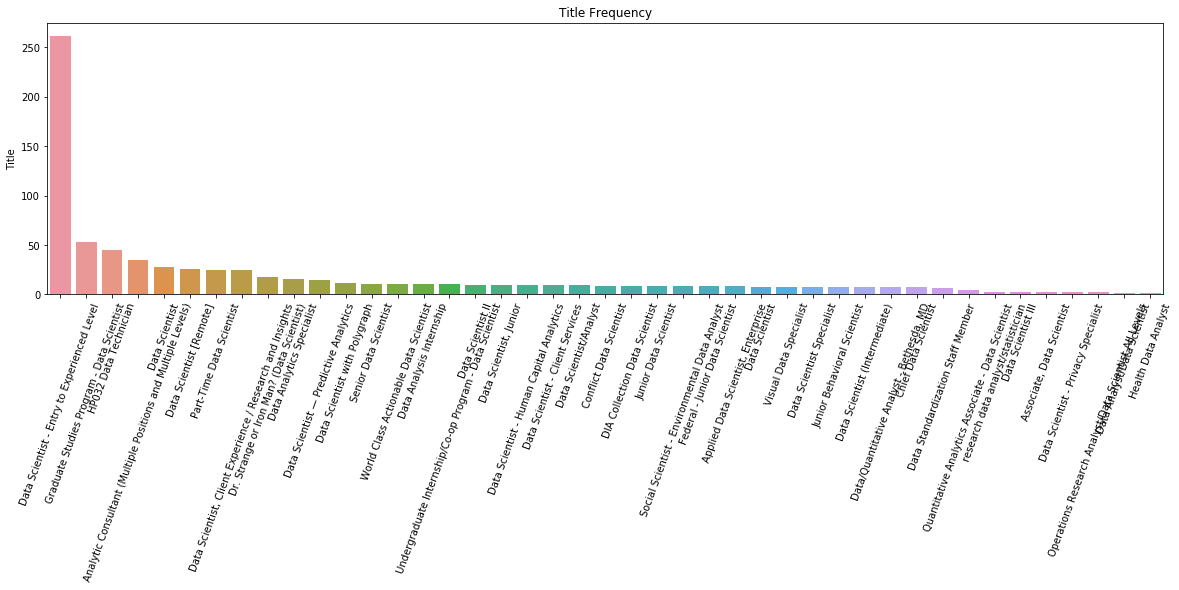

In [7]:
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Title Frequency')

sns.barplot(DC_data['Title'].unique(), DC_data['Title'].value_counts(), data=DC_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
DC_data['Title'].value_counts()

Data Scientist                                                  262
Data Analytics Specialist                                        53
Graduate Studies Program - Data Scientist                        45
Data Scientist — Predictive Analytics                            35
HP032 Data Technician                                            28
Data Scientist - Entry to Experienced Level                      26
Data Scientist with Polygraph                                    25
Data Scientist - Human Capital Analytics                         25
World Class Actionable Data Scientist                            18
Junior Data Scientist                                            16
Senior Data Scientist                                            15
Quantitative Analytics Associate - Data Scientist                12
Conflict Data Scientist                                          11
Data Scientist - Client Services                                 11
DIA Collection Data Scientist                   

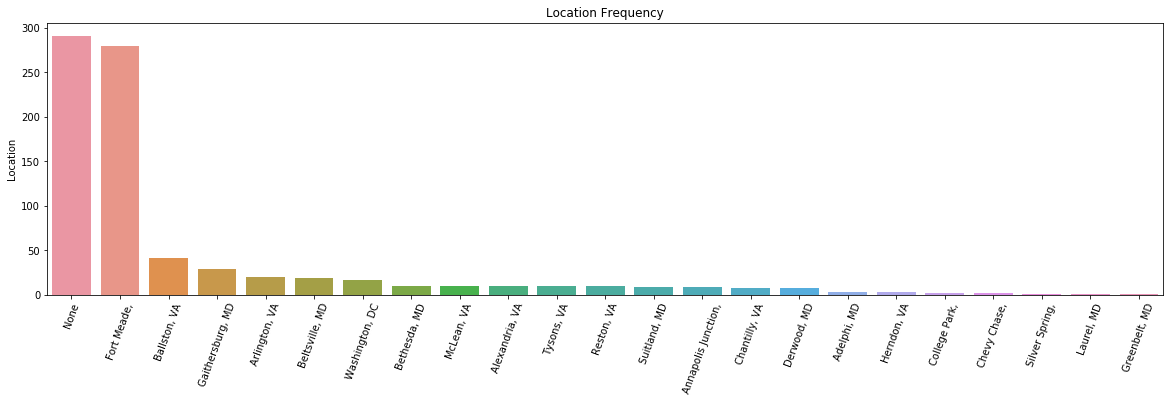

In [11]:
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')

sns.barplot(DC_data['Location'].unique(), DC_data['Location'].value_counts(), data=DC_data)

In [9]:
DC_data['Location'].value_counts()

None                   291
Washington, DC         279
Alexandria, VA          41
Arlington, VA           29
McLean, VA              20
Herndon, VA             19
College Park,           16
Reston, VA              10
Silver Spring,          10
Chantilly, VA           10
Suitland, MD            10
Annapolis Junction,     10
Adelphi, MD              9
Tysons, VA               9
Derwood, MD              8
Chevy Chase,             7
Greenbelt, MD            3
Laurel, MD               3
Bethesda, MD             2
Gaithersburg, MD         2
Beltsville, MD           1
Fort Meade,              1
Ballston, VA             1
Name: Location, dtype: int64

In [10]:
# View sample job descriptions
pd.options.display.max_colwidth = 200
DC_data['Synopsis'].head(10)

0    Applying the scientific process to data evaluation, performing statistical inference, and data mining. As a member of a technical mission office or the DSDP,...
1    As a Data Scientist Graduate Intern, you will work side-by-side with other Data Scientists to organize and interpret data to inform US decision makers, drive...
2                                               Work side by side with top scientists. HP032 Junior Data Technician, Part Time. Perform and manage system backups....
3                                  ASR has an immediate need for Analytic Consultants and Data Scientists in the Washington, DC area. Data Science and Analytics:....
4    Applying the scientific process to data evaluation, performing statistical inference, and data mining. As a member of a technical mission office or the DSDP,...
5          We are looking for Data Scientists who enjoy solving problems over a variety of different domains. § Use deep learning, machine learning and analytical...
6   

# Text Cleaning

In [12]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [14]:
# Remove annoying punctuation from the articles
DC_data['Synopsis'] = DC_data.Synopsis.map(lambda x: text_cleaner(str(x)))
DC_data['Synopsis'].head()

0    Applying the scientific process to data evaluation, performing statistical inference, and data mining. As a member of a technical mission office or the DSDP,...
1    As a Data Scientist Graduate Intern, you will work side-by-side with other Data Scientists to organize and interpret data to inform US decision makers, drive...
2                                               Work side by side with top scientists. HP032 Junior Data Technician, Part Time. Perform and manage system backups....
3                                  ASR has an immediate need for Analytic Consultants and Data Scientists in the Washington, DC area. Data Science and Analytics:....
4    Applying the scientific process to data evaluation, performing statistical inference, and data mining. As a member of a technical mission office or the DSDP,...
Name: Synopsis, dtype: object

In [18]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in DC_data['Synopsis']:
    summary = lemmatizer.lemmatize(DC_data)

TypeError: string indices must be integers

In [17]:
# Identify predictor and target variables
X = DC_data['Synopsis']
y = DC_data['Title']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

TypeError: string indices must be integers